<a href="https://colab.research.google.com/github/rohan-raj-git/Final-Project-INFO-5082/blob/main/Twitter_Sentimental_Analysis_on_Presidental_Elections_2020.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os
import time
import missingno as msno
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import nltk, re, string, collections, unicodedata


In [3]:
%matplotlib inline
from matplotlib import cm, dates
from matplotlib.ticker import ScalarFormatter
from matplotlib.ticker import FuncFormatter
from datetime import datetime, timedelta
from textblob import TextBlob
from wordcloud import WordCloud, STOPWORDS
from nltk.util import ngrams
from nltk.tokenize import word_tokenize
from nltk.classify import NaiveBayesClassifier
from nltk.corpus import subjectivity
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.util import *
from nltk.sentiment.vader import SentimentIntensityAnalyzer

/usr/local/lib/python3.7/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


**Importing the dataset**

In [4]:
Trump_review = pd.read_csv('/content/hashtag_donaldtrump.csv', lineterminator='\n')

In [5]:
Trump_review.head(15)

,created_at,tweet_id,tweet,likes,retweet_count,source,user_id,user_name,user_screen_name,user_description,user_join_date,user_followers_count,user_location,lat,long,city,country,continent,state,state_code,collected_at
0,2020-10-15 00:00:01,1.316529e+18,#Elecciones2020 | En #Florida: #JoeBiden dice ...,0.0,0.0,TweetDeck,3.606665e+08,El Sol Latino News,elsollatinonews,🌐 Noticias de interés para latinos de la costa...,2011-08-23 15:33:45,1860.0,"Philadelphia, PA / Miami, FL",25.774270,-80.193660,NaN,United States of America,North America,Florida,FL,2020-10-21 00:00:00
1,2020-10-15 00:00:01,1.316529e+18,"Usa 2020, Trump contro Facebook e Twitter: cop...",26.0,9.0,Social Mediaset,3.316176e+08,Tgcom24,MediasetTgcom24,Profilo ufficiale di Tgcom24: tutte le notizie...,2011-07-08 13:12:20,1067661.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-10-21 00:00:00.373216530
2,2020-10-15 00:00:02,1.316529e+18,"#Trump: As a student I used to hear for years,...",2.0,1.0,Twitter Web App,8.436472e+06,snarke,snarke,"Will mock for food! Freelance writer, blogger,...",2007-08-26 05:56:11,1185.0,Portland,45.520247,-122.674195,Portland,United States of America,North America,Oregon,OR,2020-10-21 00:00:00.746433060
3,2020-10-15 00:00:02,1.316529e+18,2 hours since last tweet from #Trump! Maybe he...,0.0,0.0,Trumpytweeter,8.283556e+17,Trumpytweeter,trumpytweeter,"If he doesn't tweet for some time, should we b...",2017-02-05 21:32:17,32.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-10-21 00:00:01.119649591
4,2020-10-15 00:00:08,1.316529e+18,You get a tie! And you get a tie! #Trump ‘s ra...,4.0,3.0,Twitter for iPhone,4.741380e+07,Rana Abtar - رنا أبتر,Ranaabtar,"Washington Correspondent, Lebanese-American ,c...",2009-06-15 19:05:35,5393.0,Washington DC,38.894992,-77.036558,Washington,United States of America,North America,District of Columbia,DC,2020-10-21 00:00:01.492866121
5,2020-10-15 00:00:17,1.316529e+18,@CLady62 Her 15 minutes were over long time ag...,2.0,0.0,Twitter for Android,1.138416e+09,Farris Flagg,FarrisFlagg,#BidenHarris2020 #JoeBiden2020 #KamalaHarrisFo...,2013-02-01 01:37:38,2363.0,"Perris,California",33.782519,-117.228648,NaN,United States of America,North America,California,CA,2020-10-21 00:00:01.866082651
6,2020-10-15 00:00:17,1.316529e+18,@richardmarx Glad u got out of the house! DICK...,0.0,0.0,Twitter for iPhone,7.674018e+17,Michael Wilson,wilsonfire9,NaN,2016-08-21 16:43:51,75.0,"Powell, TN",NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-10-21 00:00:02.239299182
7,2020-10-15 00:00:18,1.316529e+18,@DeeviousDenise @realDonaldTrump @nypost There...,0.0,0.0,Twitter for iPhone,9.007611e+17,Stacey Gulledge 🇺🇸 Patriot ♥️ KAG 🙏 👮‍♀️♥️,sm_gulledge,"Patriot, Wife, “Shaken not Stirred” Mom of two...",2017-08-24 16:45:49,766.0,"Ohio, USA",40.225357,-82.688140,NaN,United States of America,North America,Ohio,OH,2020-10-21 00:00:02.612515712
8,2020-10-15 00:00:20,1.316529e+18,One of the single most effective remedies to e...,0.0,0.0,Twitter Web App,5.404769e+08,Jamieo,jamieo33,"Don't know what I am. Can lean left and right,...",2012-03-30 00:30:54,151.0,"Pennsylvania, USA",40.969989,-77.727883,NaN,United States of America,North America,Pennsylvania,PA,2020-10-21 00:00:02.985732243
9,2020-10-15 00:00:21,1.316529e+18,#Election2020 #Trump \n#FreedomOfSpeech https:...,0.0,0.0,Twitter Web App,1.305533e+18,Johnny Quest,JohnnyQuest22,Independent\n\nWhat is your American Dream?\nT...,2020-09-14 15:45:18,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-10-21 00:00:03.358948773


In [6]:
Biden_review = pd.read_csv('/content/hashtag_joebiden.csv', lineterminator='\n')

In [7]:
Biden_review.head(15)

,created_at,tweet_id,tweet,likes,retweet_count,source,user_id,user_name,user_screen_name,user_description,user_join_date,user_followers_count,user_location,lat,long,city,country,continent,state,state_code,collected_at
0,2020-10-15 00:00:01,1.316529e+18,#Elecciones2020 | En #Florida: #JoeBiden dice ...,0.0,0.0,TweetDeck,3.606665e+08,El Sol Latino News,elsollatinonews,🌐 Noticias de interés para latinos de la costa...,2011-08-23 15:33:45,1860.0,"Philadelphia, PA / Miami, FL",25.774270,-80.193660,NaN,United States of America,North America,Florida,FL,2020-10-21 00:00:00
1,2020-10-15 00:00:18,1.316529e+18,#HunterBiden #HunterBidenEmails #JoeBiden #Joe...,0.0,0.0,Twitter for iPad,8.099044e+08,Cheri A. 🇺🇸,Biloximeemaw,"Locked and loaded Meemaw. Love God, my family ...",2012-09-08 01:03:57,6628.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-10-21 00:00:00.517827283
2,2020-10-15 00:00:20,1.316529e+18,@IslandGirlPRV @BradBeauregardJ @MeidasTouch T...,0.0,0.0,Twitter Web App,3.494182e+09,Flag Waver,Flag_Wavers,NaN,2015-08-30 19:38:21,1536.0,Golden Valley Arizona,46.304036,-109.171431,NaN,United States of America,North America,Montana,MT,2020-10-21 00:00:01.035654566
3,2020-10-15 00:00:21,1.316529e+18,@chrislongview Watching and setting dvr. Let’s...,0.0,0.0,Twitter for iPhone,8.242596e+17,Michelle Ferg,MichelleFerg4,NaN,2017-01-25 14:16:17,27.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-10-21 00:00:01.553481849
4,2020-10-15 00:00:22,1.316529e+18,#censorship #HunterBiden #Biden #BidenEmails #...,1.0,0.0,Twitter Web App,1.032807e+18,the Gold State,theegoldstate,A Silicon Valley #independent #News #Media #St...,2018-08-24 01:49:01,390.0,"California, USA",36.701463,-118.755997,NaN,United States of America,North America,California,CA,2020-10-21 00:00:02.071309132
5,2020-10-15 00:00:23,1.316529e+18,"""IS THIS WRONG??!!"" Cory Booker's BRILLIANT Fi...",0.0,0.0,Twitter Web App,3.057279e+08,Dose of Dissonance,Dose_Dissonance,YOUTUBE CHANNEL: https://t.co/EFnKm5gnvV MERCH...,2011-05-26 18:09:32,4622.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-10-21 00:00:02.589136415
6,2020-10-15 00:00:25,1.316529e+18,"In 2020, #NYPost is being #censorship #CENSORE...",0.0,0.0,Twitter for iPhone,1.994033e+07,Change Illinois | Biden will increase taxes by...,changeillinois,"Illinois, home of Lincoln and Reagan, used to ...",2009-02-02 23:08:28,1397.0,"Chicago, Illinois",41.875562,-87.624421,Chicago,United States of America,North America,Illinois,IL,2020-10-21 00:00:03.106963698
7,2020-10-15 00:00:31,1.316529e+18,►► Tell Politicians to STICK IT with this FREE...,0.0,0.0,Freebie-Depot,1.030832e+08,🆓 Freebie Depot,FreebieDepot,Free Stuff - No Fluff! Get all kinds of FREE ...,2010-01-08 20:44:21,6402.0,USA - Land of the FREE!,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-10-21 00:00:03.624790981
8,2020-10-15 00:00:36,1.316529e+18,#Biden https://t.co/qMs0PmUev5,0.0,0.0,Twitter Web App,1.272568e+18,Kenneth,Kennethuteliv,NaN,2020-06-15 16:35:31,103.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-10-21 00:00:04.142618264
9,2020-10-15 00:00:41,1.316529e+18,Proof Bidens are crooked. Twitter will suspen...,1.0,1.0,Twitter for Android,1.275659e+18,Jake Rivendale,JakeRivendale,NaN,2020-06-24 05:15:06,80.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-10-21 00:00:04.660445547


**Data Cleaning**

In [8]:
Trump_review['country'].replace({'United States':'United States of America'}, inplace=True)
Biden_review['country'].replace({'United States':'United States of America'}, inplace=True)

In [9]:
#Features Added

def normalise(x,y):
    x = np.array(x)
    y = np.array(y)
    return np.where(x == 0, 0, x / y)

def sentiment(data):
    temp=[]
    for row in data:
        tmp=sid.polarity_scores(row)
        temp.append(tmp)
    return temp

In [10]:
Data = pd.concat([Trump_review,Biden_review])
Data.sort_values(by='created_at')

,created_at,tweet_id,tweet,likes,retweet_count,source,user_id,user_name,user_screen_name,user_description,user_join_date,user_followers_count,user_location,lat,long,city,country,continent,state,state_code,collected_at
0,2020-10-15 00:00:01,1.316529e+18,#Elecciones2020 | En #Florida: #JoeBiden dice ...,0.0,0.0,TweetDeck,3.606665e+08,El Sol Latino News,elsollatinonews,🌐 Noticias de interés para latinos de la costa...,2011-08-23 15:33:45,1860.0,"Philadelphia, PA / Miami, FL",25.774270,-80.193660,NaN,United States of America,North America,Florida,FL,2020-10-21 00:00:00
0,2020-10-15 00:00:01,1.316529e+18,#Elecciones2020 | En #Florida: #JoeBiden dice ...,0.0,0.0,TweetDeck,3.606665e+08,El Sol Latino News,elsollatinonews,🌐 Noticias de interés para latinos de la costa...,2011-08-23 15:33:45,1860.0,"Philadelphia, PA / Miami, FL",25.774270,-80.193660,NaN,United States of America,North America,Florida,FL,2020-10-21 00:00:00
1,2020-10-15 00:00:01,1.316529e+18,"Usa 2020, Trump contro Facebook e Twitter: cop...",26.0,9.0,Social Mediaset,3.316176e+08,Tgcom24,MediasetTgcom24,Profilo ufficiale di Tgcom24: tutte le notizie...,2011-07-08 13:12:20,1067661.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-10-21 00:00:00.373216530
2,2020-10-15 00:00:02,1.316529e+18,"#Trump: As a student I used to hear for years,...",2.0,1.0,Twitter Web App,8.436472e+06,snarke,snarke,"Will mock for food! Freelance writer, blogger,...",2007-08-26 05:56:11,1185.0,Portland,45.520247,-122.674195,Portland,United States of America,North America,Oregon,OR,2020-10-21 00:00:00.746433060
3,2020-10-15 00:00:02,1.316529e+18,2 hours since last tweet from #Trump! Maybe he...,0.0,0.0,Trumpytweeter,8.283556e+17,Trumpytweeter,trumpytweeter,"If he doesn't tweet for some time, should we b...",2017-02-05 21:32:17,32.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-10-21 00:00:01.119649591
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
970917,2020-11-08 23:59:54,1.325589e+18,"@sammelbis1998 @iheartmindy @bnorthg First, yo...",0.0,0.0,Twitter for iPad,7.687811e+08,Debra,drdeblk,MD. Autism specialist. Film lover. #DumpTrump2020,2012-08-20 03:53:11,1079.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-11-09 17:47:56.012674
970918,2020-11-08 23:59:55,1.325589e+18,OK just had to do it !\n#Trump #CatapultTrump ...,105.0,28.0,Twitter Web App,4.519791e+08,Dunken K Bliths,DunkenKBliths,"""Tesla owner's will be followed back""\n\n#Mach...",2012-01-01 08:04:29,12192.0,✔ Official Twitter Account,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-11-09 17:47:55.807500
922910,2020-11-08 23:59:56,1.325589e+18,@nbcbayarea Who doesn’t like dogs or any kind ...,1.0,1.0,Twitter for iPhone,1.182639e+08,Dianna Maria,DiannaMaria,"~ I am a very proud mom of a sweet, kind and c...",2010-02-28 03:31:22,1462.0,United States,39.783730,-100.445882,NaN,United States of America,North America,NaN,NaN,2020-11-09 17:46:06.939099
737089,2020-11-08 23:59:57,1.325589e+18,#JoeBiden 😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂 https://t.co/Ym...,0.0,0.0,Twitter for iPhone,1.148479e+08,Nataša,PewPeeew,My brain consists of coping mechanisms and vin...,2010-02-16 20:10:35,33.0,Deutschland,51.083420,10.423447,NaN,Germany,Europe,NaN,NaN,2020-11-09 18:26:04.550843


**Exploratory Data Analysis**

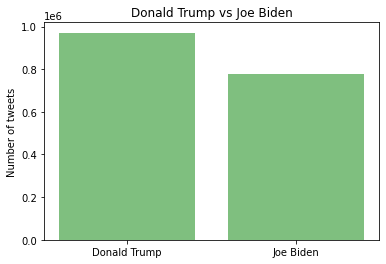

In [11]:
#Number of Tweets 
Trump_review.loc[:,'condidat'] = 'Trump'
Trump_tweets = Trump_review.query('(condidat == "Trump")').tweet.sort_values(ascending=False).count()
Biden_review.loc[:,'condidat'] = 'Biden'
Biden_tweets = Biden_review.query('(condidat == "Biden")').tweet.sort_values(ascending=False).count()

objects = ('Donald Trump','Joe Biden')
y_pos = np.arange(len(objects))
performance = [Trump_tweets,Biden_tweets]

plt.bar(y_pos, performance, align='center', alpha=0.5, color='green')
plt.xticks(y_pos, objects)
plt.ylabel('Number of tweets')
plt.title('Donald Trump vs Joe Biden')

plt.show()

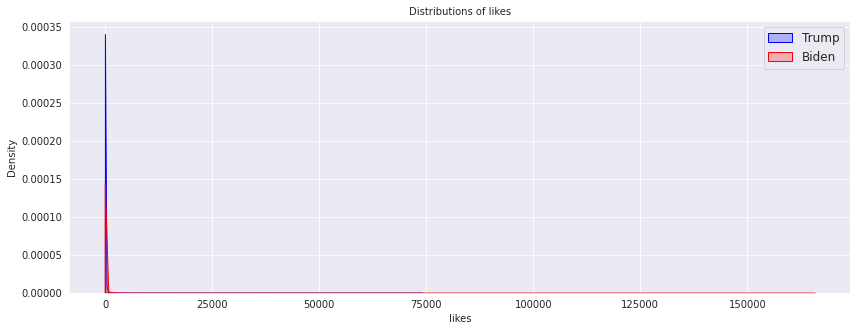

In [12]:
#Distribution of Likes
sns.set_style("darkgrid")
plt.figure(figsize=(14, 5))

sns.kdeplot(Trump_review['likes'], label = 'Trump', shade = True, color = 'blue')
sns.kdeplot(Biden_review['likes'], label = 'Biden', shade = True, color = 'red')
plt.title('Distributions of likes', size = 10)
plt.legend(prop={'size': 12})
plt.show()

In [13]:
Trump_review.sort_values('likes', ascending = False)[:5]

,created_at,tweet_id,tweet,likes,retweet_count,source,user_id,user_name,user_screen_name,user_description,user_join_date,user_followers_count,user_location,lat,long,city,country,continent,state,state_code,collected_at,condidat
786530,2020-11-06 16:31:06,1.324751e+18,America Assembled!🇺🇸🎉\n\n@JoeBiden @KamalaHarr...,74084.0,20491.0,Twitter for iPhone,3.836269e+07,John Handem Piette,JohnHPiette,"Director, Editor, Actor living the dream in Lo...",2009-05-07 03:55:16,8033.0,"Brooklyn, NY",40.650102,-73.949583,New York,United States of America,North America,New York,NY,2020-11-07 11:20:11.759392,Trump
548591,2020-11-04 04:12:07,1.323840e+18,How did they call California for Joe Biden 8 m...,35449.0,6629.0,Twitter for iPhone,4.729379e+07,Terrence K. Williams,w_terrence,Actor• Comedian• My New Book “ From The Foster...,2009-06-15 08:46:13,1190959.0,United States,39.783730,-100.445882,NaN,United States of America,North America,NaN,NaN,2020-11-05 12:16:23.532171,Trump
223920,2020-10-24 19:56:33,1.320092e+18,Experienced my first #Trump parade today....an...,26039.0,12181.0,Twitter for iPhone,8.015638e+17,Skillset Magazine,Skillsetmag,Redefining the Alpha Lifestyle 🇺🇸 Available na...,2016-11-23 23:11:13,5645.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-10-27 17:42:32.283461,Trump
245075,2020-10-26 00:08:24,1.320518e+18,The White House still has not released a healt...,25987.0,5986.0,Twitter for iPhone,2.126745e+08,Paula Reid,PaulaReidCBS,@CBSNews White House Correspondent. Lawyer. re...,2010-11-06 18:45:01,318675.0,Washington DC,38.894992,-77.036558,Washington,United States of America,North America,District of Columbia,DC,2020-10-27 17:38:26.623985,Trump
818751,2020-11-07 04:36:44,1.324934e+18,#trump wants to throw out military ballots? W...,23225.0,1851.0,Twitter for iPhone,1.398238e+08,bettemidler,BetteMidler,It’s today!,2010-05-03 20:00:36,2042681.0,"New York, NY",40.712728,-74.006015,New York,United States of America,North America,New York,NY,2020-11-08 10:59:25.539439,Trump


In [14]:
Biden_review.sort_values('likes', ascending = False)[:5]

,created_at,tweet_id,tweet,likes,retweet_count,source,user_id,user_name,user_screen_name,user_description,user_join_date,user_followers_count,user_location,lat,long,city,country,continent,state,state_code,collected_at,condidat
20432,2020-10-16 03:17:29,1.316941e+18,Tonight a woman in the audience of Trump's tow...,165702.0,17652.0,Twitter Web App,139823781.0,bettemidler,BetteMidler,Kindness is the language which the deaf can he...,2010-05-03 20:00:36,2028360.0,"New York, NY",40.712728,-74.006015,New York,United States of America,North America,New York,NY,2020-10-21 02:59:56.181023787,Biden
10623,2020-10-15 17:09:02,1.316788e+18,The cowards at Twitter locked me out for expos...,143454.0,63473.0,Twitter for iPhone,78523300.0,James Woods,RealJamesWoods,This is the ONLY verified Twitter account for ...,2009-09-30 05:31:28,2685154.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-10-21 01:33:56.032148443,Biden
298112,2020-11-02 15:25:15,1.323285e+18,Good morning PENNSYLVANIA! I’m so excited to s...,126772.0,14024.0,Twitter for iPhone,14230524.0,Lady Gaga,ladygaga,“Chromatica” ⚔️💓 OUT NOW https://t.co/137uGkbr...,2008-03-26 22:37:48,82417077.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-11-03 14:34:27.602657,Biden
278831,2020-11-01 18:08:59,1.322964e+18,That’s a pic of me in Pennsylvania when I live...,80670.0,7553.0,Twitter for iPhone,14230524.0,Lady Gaga,ladygaga,“Chromatica” ⚔️💓 OUT NOW https://t.co/137uGkbr...,2008-03-26 22:37:48,82396325.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-11-02 16:18:06.846254,Biden
536374,2020-11-06 16:31:06,1.324751e+18,America Assembled!🇺🇸🎉\n\n@JoeBiden @KamalaHarr...,74528.0,20615.0,Twitter for iPhone,38362690.0,John Handem Piette,JohnHPiette,"Director, Editor, Actor living the dream in Lo...",2009-05-07 03:55:16,8080.0,"Brooklyn, NY",40.650102,-73.949583,New York,United States of America,North America,New York,NY,2020-11-07 11:40:57.159884,Biden


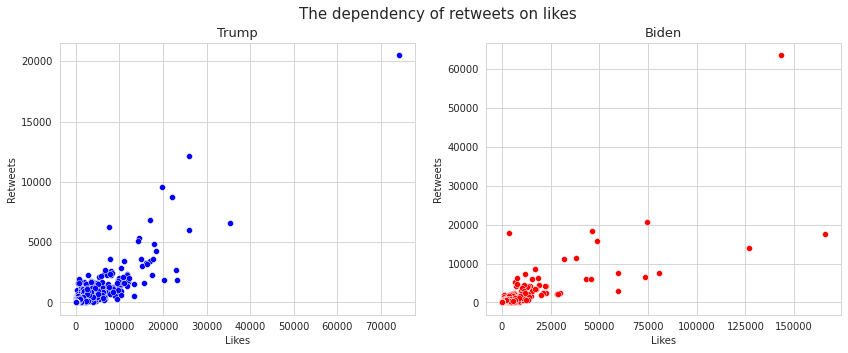

In [16]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
sns.set_style("whitegrid")
fig.suptitle("The dependency of retweets on likes", size = 15)

sns.scatterplot(x = Trump_review['likes'], y = Trump_review['retweet_count'],
                color = 'blue', ax = ax1)
ax1.get_yaxis().get_major_formatter().set_scientific(False)
ax1.set_xlabel('Likes')
ax1.set_ylabel('Retweets')
ax1.set_title('Trump', size = 13)


sns.scatterplot(x = Biden_review['likes'], y = Biden_review['retweet_count'],
                color = 'red', ax = ax2)
ax2.get_yaxis().get_major_formatter().set_scientific(False)
ax2.set_xlabel('Likes')
ax2.set_ylabel('Retweets')
ax2.set_title('Biden', size = 13)

fig.show()

In [17]:
#Correlation b/w likes and retweets

print('Correlation between likes and retweets (Trump): {}'.
      format(Trump_review['likes'].corr(Trump_review['retweet_count'])))
print('Correlation between likes and retweets (Biden): {}'.
      format(Biden_review['likes'].corr(Biden_review['retweet_count'])))

Correlation between likes and retweets (Trump): 0.8805100805658704
Correlation between likes and retweets (Biden): 0.793622459653326


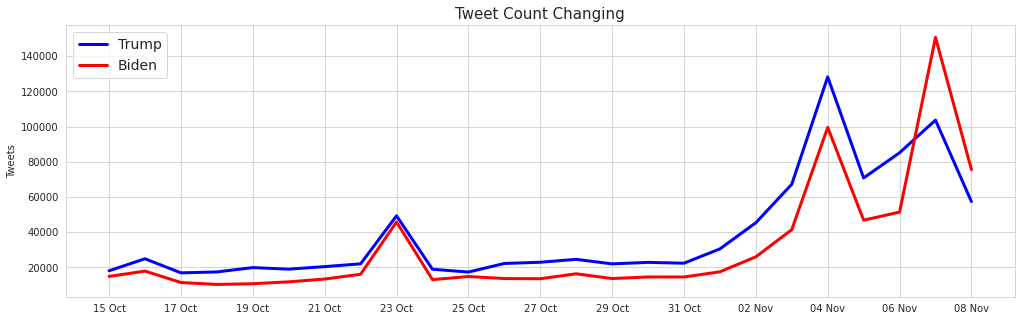

In [18]:
import matplotlib.dates as mdates
sns.set_style("whitegrid")
plt.figure(figsize=(17, 5))

ax = sns.lineplot(data = pd.to_datetime(Trump_review.created_at).dt.date.value_counts(), 
                  label = 'Trump', color = 'blue', linewidth = 3)
ax = sns.lineplot(data = pd.to_datetime(Biden_review.created_at).dt.date.value_counts(), 
                  label = 'Biden', color = 'red', linewidth = 3)
ax.xaxis.set_major_locator(mdates.DayLocator(interval=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d %b'))

plt.title('Tweet Count Changing', size = 15)
plt.legend(prop={'size': 14})
plt.ylabel('Tweets')
plt.show()

**Cleaning Tweets**


In [19]:
Trump_review['tweet'][19529]

'Mad #Trump: "I borrowed the $400 million as a favor to those banks!"\n💰🤡💰\n\n(He keeps saying he\'s "underlevered" instead of "underleveraged" -which, of course, he\'s not.) \n\n#25thAmendmentNow'

In [20]:
Biden_review['tweet'][11650]

'Hallo Twitter,\nwarum unterdrückst du eigentlich Nachrichten über Hunter #Biden? Hast du das überhaupt mit Barbra #Streisand abgesprochen? https://t.co/IUA98qkeBg'

In [21]:
#Cleaning Tweets
def tweet_cleaner(text):
    text = text.lower()
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    text = re.sub('\[.*?\]', ' ', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', ' ', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [22]:
trump_cleaned = Trump_review.copy()
biden_cleaned = Biden_review.copy()

trump_cleaned['tweet'] = trump_cleaned['tweet'].apply(lambda x: tweet_cleaner(x))
biden_cleaned['tweet'] = biden_cleaned['tweet'].apply(lambda x: tweet_cleaner(x))

In [23]:
trump_cleaned['tweet'][19529]

'mad trump i borrowed the  million as a favor to those banks   he keeps saying hes underlevered instead of underleveraged which of course hes not   '

In [24]:
biden_cleaned['tweet'][11650]

'hallo twitter warum unterdruckst du eigentlich nachrichten uber hunter biden hast du das uberhaupt mit barbra streisand abgesprochen '

**Length of Tweets**

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


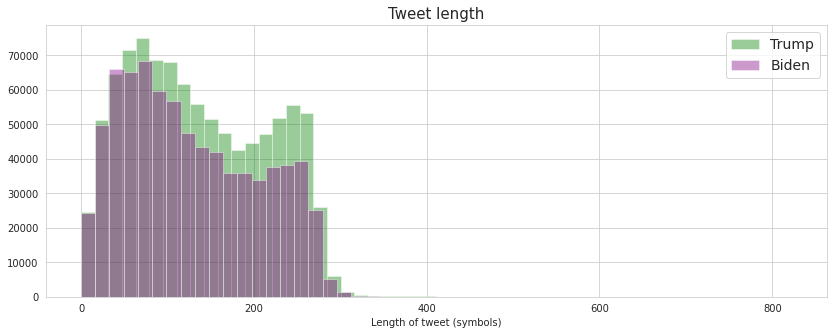

In [25]:
trump_tweet_length = trump_cleaned.tweet.str.len()
biden_tweet_length = biden_cleaned.tweet.str.len()

sns.set_style("whitegrid")
plt.figure(figsize=(14, 5))

sns.distplot(trump_tweet_length, label = 'Trump', color = 'green', kde = False)
sns.distplot(biden_tweet_length, label = 'Biden', color = 'purple', kde = False)
plt.legend(prop={'size': 14})
plt.title('Tweet length', size = 15)
plt.xlabel('Length of tweet (symbols)')
plt.show()

**Creating Word Lists**

In [26]:
trump_corpus = []
words = trump_cleaned['tweet'].str.split().values.tolist()
trump_corpus = [word for i in words for word in i]

biden_corpus = []
words = biden_cleaned['tweet'].str.split().values.tolist()
biden_corpus = [word for i in words for word in i]

**Word Frequency**

In [27]:
from collections import Counter, defaultdict
trump_counter = Counter(trump_corpus)
trump_most = trump_counter.most_common()

biden_counter = Counter(biden_corpus)
biden_most = biden_counter.most_common()

In [28]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS
stop = set(np.concatenate((stopwords.words('english'), stopwords.words('spanish'))))

trump_x, trump_y = [], []
for word, count in trump_most[:100]:
    if word not in stop:
        trump_x.append(word)
        trump_y.append(count)
        
biden_x, biden_y = [], []
for word, count in biden_most[:100]:
    if word not in stop:
        biden_x.append(word)
        biden_y.append(count)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


**Top 20 words**

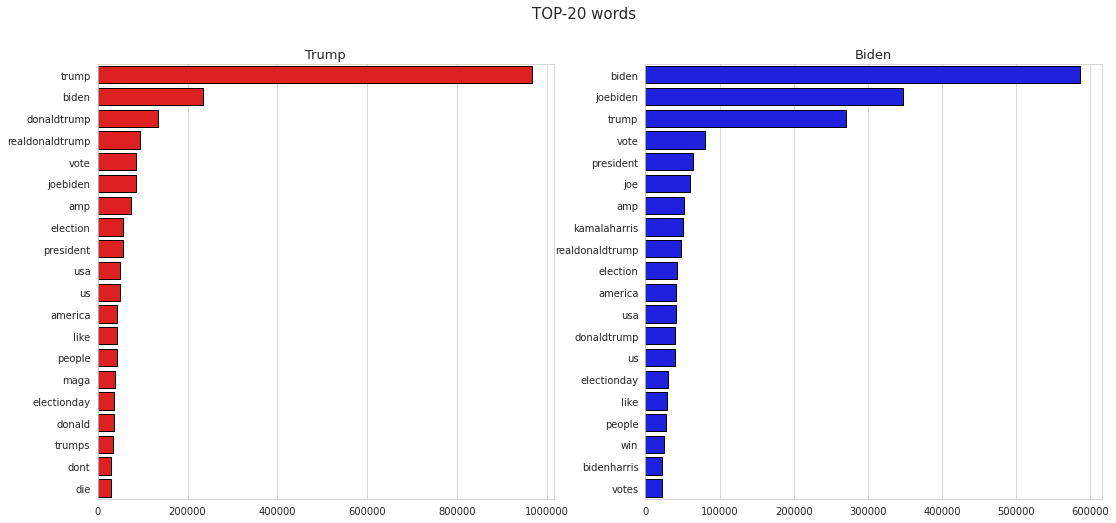

In [29]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))
sns.set_style("whitegrid")
plt.suptitle('TOP-20 words', size = 15)

sns.barplot(x = trump_y[:20], y = trump_x[:20], edgecolor = 'black', color = 'red', ax = ax1)
ax1.set_title('Trump', size = 13)
ax1.get_xaxis().get_major_formatter().set_scientific(False)

sns.barplot(x = biden_y[:20], y = biden_x[:20], edgecolor = 'black', color = 'blue', ax = ax2)
ax2.set_title('Biden', size = 13)
ax2.get_xaxis().get_major_formatter().set_scientific(False)

fig.show()

In [30]:
def show_wordcloud(data, title = None, color = 'white'):
    wordcloud = WordCloud(background_color=color,
                         stopwords=stop,
                         max_words=10000,
                         scale=3,
                         width = 4000, 
                         height = 2000,
                         collocations=False,
                         random_state=1)
    
    wordcloud = wordcloud.generate(str(data))
    
    plt.figure(1, figsize=(16, 8))
    plt.title(title, size = 15)
    plt.axis('off')
    plt.imshow(wordcloud)
    plt.show()

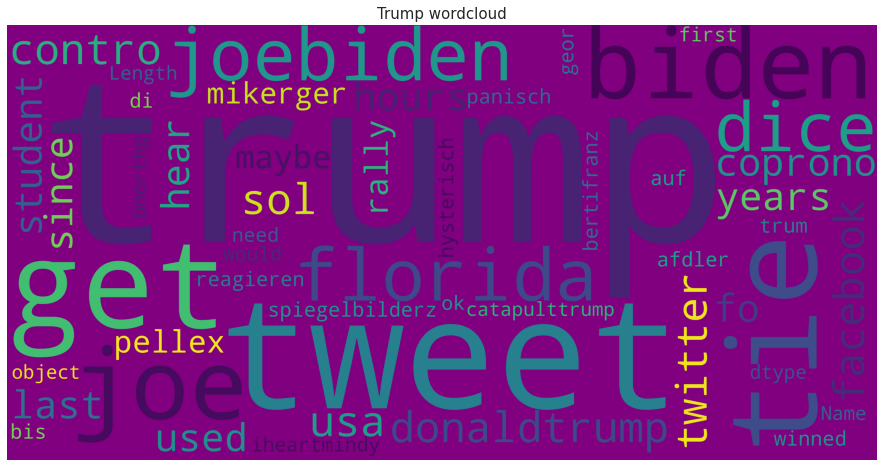

In [31]:
show_wordcloud(trump_cleaned['tweet'].dropna(), title = 'Trump wordcloud', color = 'purple')


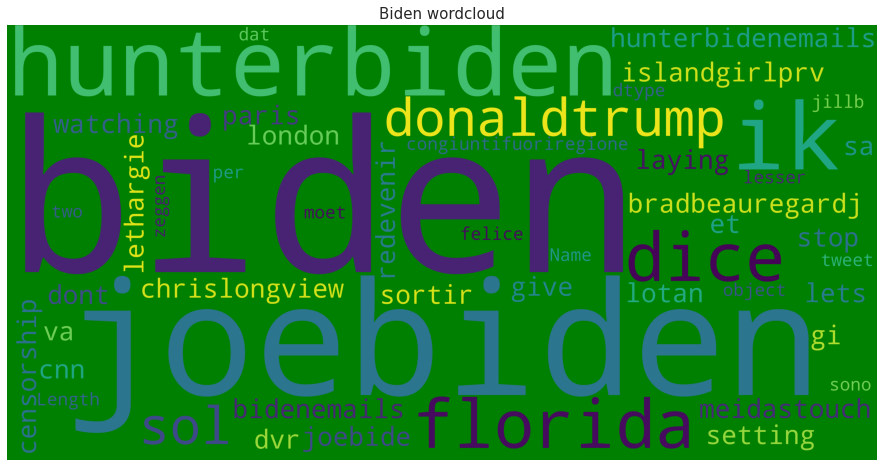

In [32]:
show_wordcloud(biden_cleaned['tweet'].dropna(), title = 'Biden wordcloud', color = 'green')

**SENTIMENT ANALYSIS USING TEXTBLOB**

In [33]:
def polarity(data):
    return TextBlob(data).sentiment.polarity
trump_cleaned['polarity'] = trump_cleaned['tweet'].apply(lambda x: polarity(x))
biden_cleaned['polarity'] = biden_cleaned['tweet'].apply(lambda x: polarity(x))

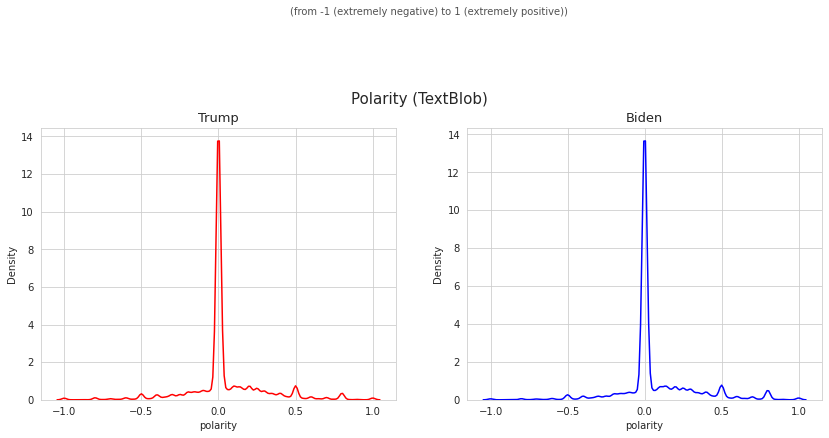

In [34]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
sns.set_style("whitegrid")
plt.suptitle('Polarity (TextBlob)', size = 15)
plt.text(x=-2.3, y=20.3, s='(from -1 (extremely negative) to 1 (extremely positive))', fontsize=10, alpha=0.8)


sns.kdeplot(trump_cleaned['polarity'], color = 'red', ax = ax1, legend = False)
ax1.set_title('Trump', size = 13)

sns.kdeplot(biden_cleaned['polarity'], color = 'blue', ax = ax2, legend = False)
ax2.set_title('Biden', size = 13)

fig.show()

**Trump Negative Tweets**

In [35]:
trump_cleaned[trump_cleaned['polarity'] == -1]['tweet'][:5]

27      comments on this do democrats understand how r...
217     the thought of having to hear the insane ravin...
694                 trump is the worst president ever    
976     schoolchoice vote freedom trump whyvoteleft di...
1039    presidential debate trumps insult to biden fam...
Name: tweet, dtype: object

**Trump Positive Tweets**

In [36]:
trump_cleaned[trump_cleaned['polarity'] == 1]['tweet'][:5]

211    via rawstory its been one faceplant after anot...
437                how awesome my twitterversary  trump 
560    excellent show him the door  cdnpoli abpoli us...
663    realdonaldtrump another best people from trump...
740          mummy always knows best  trump  uspolitics 
Name: tweet, dtype: object

**Biden Negative Tweets**

In [37]:
biden_cleaned[biden_cleaned['polarity'] == -1]['tweet'][:5]

17     comments on this do democrats understand how r...
142    bye bye biden watching tuckercarlson  devastating
359    no today were going to make the evil nutter a ...
891    cocainelaced cigarettes crack and vodka binges...
994    presidential debate trumps insult to biden fam...
Name: tweet, dtype: object

**Biden Positive Tweets**

In [38]:
biden_cleaned[biden_cleaned['polarity'] == 1]['tweet'][:5]

649     joe biden at his best remember when joebiden c...
1254    excellent analysis by tucker carlson of bidene...
1262    chrismegerian no it just publishes the email f...
1456    we gave obama and vp joebiden a democrat congr...
1526    the best way for joebiden to tackle the nypost...
Name: tweet, dtype: object

**SENTIMENT ANALYSIS USING VADER ANALYZER**



In [39]:
import nltk
nltk.download('vader_lexicon')
sid = SentimentIntensityAnalyzer()
def get_vader_score(data):
    return sid.polarity_scores(data)['compound']

trump_cleaned['VADER'] = trump_cleaned['tweet'].apply(lambda x: get_vader_score(x))
biden_cleaned['VADER'] = biden_cleaned['tweet'].apply(lambda x: get_vader_score(x))

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


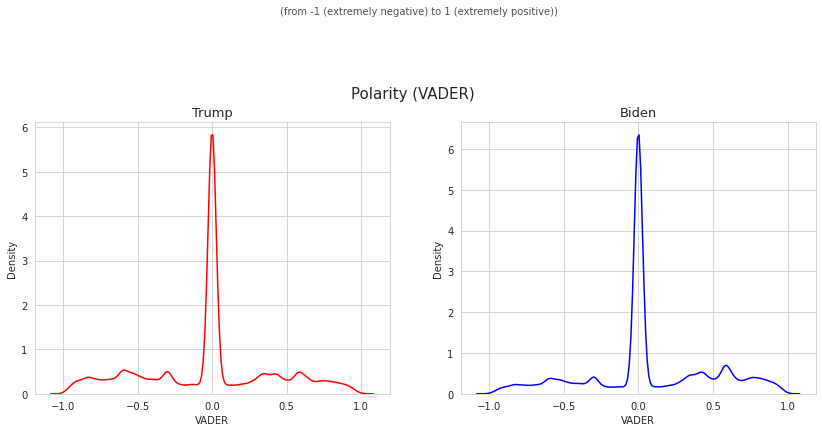

In [40]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
sns.set_style("whitegrid")
plt.suptitle('Polarity (VADER)', size = 15)
plt.text(x=-2.4, y=9.3, s='(from -1 (extremely negative) to 1 (extremely positive))', fontsize=10, alpha=0.8)


sns.kdeplot(trump_cleaned['VADER'], color = 'red', ax = ax1, legend = False)
ax1.set_title('Trump', size = 13)

sns.kdeplot(biden_cleaned['VADER'], color = 'blue', ax = ax2, legend = False)
ax2.set_title('Biden', size = 13)

fig.show()

In [41]:
print(trump_cleaned['tweet'].loc[945451])
print('*'*20)
print(trump_cleaned[['polarity', 'VADER']].loc[945451])

 peterbeinart ive disowned family and i have removed friends from my circle it has been really hard as some of my friends were closer than my family ever was but voting for trump is voting for sexualassault bigotry hate ignorance hypocrisy autocracy failure and more
********************
polarity   -0.227083
VADER      -0.900000
Name: 945451, dtype: float64


In [42]:
print(biden_cleaned['tweet'].loc[296157])
print('*'*20)
print(biden_cleaned[['polarity', 'VADER']].loc[296157])

mondaythoughts i believe melaniatrump is voting for biden when she speaks it seems rehearsed or forced she never appears happy in public with donnie she knows shes in captivity amp itll be hell to pay if she wants out
********************
polarity    0.175
VADER      -0.900
Name: 296157, dtype: float64


**Trump Tweets Sentiment Analysis**

In [43]:
def clean(text):
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    text=re.sub(r'@[A-Za-z0-9]+','',text)
    text=re.sub(r'#','',text)
    text=re.sub(r'RT[\s]+','',text)
    text=re.sub(r'[^\w]', ' ', text)
    return text

In [44]:
def getSubjectivity(text):
    return TextBlob(text).sentiment.subjectivity
def getPolarity(text):
    return TextBlob(text).sentiment.polarity
def getAnalysis(score):
    if score < 0:
        return 'negative'
    elif score==0:
        return 'neutral'
    else:
        return 'positive'

In [45]:
Trump_review.loc[:,'condidat'] = 'Trump'
Trump_Tweets = Trump_review.query('(condidat == "Trump")').sort_values('user_followers_count',ascending = False).drop_duplicates(['user_name'])[['tweet','country']]
Trump_Tweets = Trump_Tweets.dropna().loc[Trump_Tweets.country == 'United States of America'][:1000]

Trump_Tweets.reset_index(inplace = True, drop = True)

Trump_Tweets['ClearTweet'] = Trump_Tweets['tweet'].apply(clean)

Trump_Tweets['subjectivity']= Trump_Tweets['ClearTweet'].apply(getSubjectivity)
Trump_Tweets['polarity']    = Trump_Tweets['ClearTweet'].apply(getPolarity)
Trump_Tweets['analysis']    = Trump_Tweets['polarity'].apply(getAnalysis)
Trump_Tweets.head()

,tweet,country,ClearTweet,subjectivity,polarity,analysis
0,"Without a doubt, the #FourSeasons debacle is t...",United States of America,without a doubt the fourseasons debacle is th...,0.483333,0.333333,positive
1,"President Donald #Trump’s youngest daughter, T...",United States of America,president donald trump s youngest daughter ti...,0.000000,0.000000,neutral
2,Woah. Have you read this article?\n\nAll the p...,United States of America,woah have you read this article all the presi...,0.000000,0.000000,neutral
3,The latest episode of #SNL tackled #DonaldTrum...,United States of America,the latest episode of snl tackled donaldtrump ...,0.800000,-0.033333,negative
4,🇺🇸 #Decision2020: @JoeBiden firmará una serie ...,United States of America,firmará una serie de órdenes ejecutivas ...,0.000000,0.000000,neutral


In [46]:
import plotly.graph_objects as go
general  = Trump_Tweets.groupby('analysis').analysis.count()
neutral  = Trump_Tweets[Trump_Tweets['analysis'] == 'neutral'].ClearTweet.count()
positive = Trump_Tweets[Trump_Tweets['analysis'] == 'positive'].ClearTweet.count()
negative = Trump_Tweets[Trump_Tweets['analysis'] == 'negative'].ClearTweet.count()

fig = go.Figure(data = [go.Funnelarea(labels = ["positivity","negativity","neutrality"], values = [positive,negative,neutral])])
fig.update_layout(title_text ='Trump Tweets Sentiment Analysis')
fig.show()

**Biden Tweets Sentiment Analysis**

In [47]:
Biden_Tweets = Biden_review.query('(condidat == "Biden")').sort_values('user_followers_count',ascending = False).drop_duplicates(['user_name'])[['tweet','country']]
Biden_Tweets = Biden_Tweets.dropna().loc[Biden_Tweets.country == 'United States of America'][:1000]


Biden_Tweets.reset_index(inplace = True, drop = True)

Biden_Tweets['ClearTweet'] = Biden_Tweets['tweet'].apply(clean)

 
Biden_Tweets['subjectivity']= Biden_Tweets['ClearTweet'].apply(getSubjectivity)
Biden_Tweets['polarity']    = Biden_Tweets['ClearTweet'].apply(getPolarity)
Biden_Tweets['analysis']    = Biden_Tweets['polarity'].apply(getAnalysis)
Biden_Tweets.head()


Biden_Tweets.head()

,tweet,country,ClearTweet,subjectivity,polarity,analysis
0,#JoeBiden is enlisting A-list star power to he...,United States of America,joebiden is enlisting a list star power to hel...,0.00,0.00,neutral
1,While we were campaigning across battleground ...,United States of America,while we were campaigning across battleground ...,0.75,0.80,positive
2,The big fight TODAY!!!!! @realDonaldTrump vs #...,United States of America,the big fight today vs joebiden who you ...,0.10,0.00,neutral
3,News outlets have projected that #JoeBiden has...,United States of America,news outlets have projected that joebiden has ...,0.00,0.00,neutral
4,"During his victory speech, #JoeBiden said he u...",United States of America,during his victory speech joebiden said he un...,0.75,-0.75,negative


In [48]:
general  = Biden_Tweets.groupby('analysis').analysis.count()
neutral  = Biden_Tweets[Biden_Tweets['analysis'] == 'neutral'].ClearTweet.count()
positive = Biden_Tweets[Biden_Tweets['analysis'] == 'positive'].ClearTweet.count()
negative = Biden_Tweets[Biden_Tweets['analysis'] == 'negative'].ClearTweet.count()

fig = go.Figure(data = [go.Funnelarea(labels = ["positivity","negativity","neutrality"], values = [positive,negative,neutral])])
fig.update_layout(title_text ='Joe Biden Tweets Sentiment Analysis')
fig.show()